# Comparing fitted model to TNG50, TNG100, and TNG300

In [46]:
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy import stats

#from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2018
from astropy.cosmology import z_at_value
from astropy.table import Table

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import paths
import init_values as In
import MassDistHelperFunctions as mfunc
#import Plot_Mass_distributions as pltmass

In [47]:
data_dir    =  str(paths.data) +'/'
save_loc = str(paths.figures) + '/'
COMPASfilename = 'COMPAS_Output_wWeights.h5'

filenames = ['SFRMetallicityFromGasTNG50-1.hdf5', 'SFRMetallicityFromGasTNG100-1.hdf5', 'SFRMetallicityFromGasTNG300-1.hdf5'] 
            #'SFRMetallicityFromGasTNG100-2.hdf5'] #, 'SFRMetallicityFromGasTNG50-2.hdf5', 'SFRMetallicityFromGasTNG50-3.hdf5']
rates = ['Rate_info_TNG50.h5', 'Rate_info_TNG100.h5', 'Rate_info_TNG300.h5']#, 'Rate_info_TNG100-2.h5'] #, 'Rate_info_TNG50-2.h5', 'Rate_info_TNG50-3.h5']
fit_params = ['test_best_fit_parameters_TNG50.txt', 'test_best_fit_parameters_TNG100.txt', 'test_best_fit_parameters_TNG300.txt']
              #'test_best_fit_parameters_TNG100-2.txt'] #, 'test_best_fit_parameters_TNG50-2.txt', 'test_best_fit_parameters_TNG50-3.txt']
Rboxvals = [35, 75, 205, 75, 35, 35]
fit_colors = ['#044082', '#2b7fd9', '#73b1f5', '#168f9e', '#2fc3d6', '#5ed7e6']
labels = ['50-1', '100-1', '300-1']
data_colors = ['#c74d22', '#eb6a3d', '#fe875d', '#35801c', '#4fb52d', '#82e660']

In [48]:
"""
#remove omega_z
filenames = ['SFRMetallicityFromGasTNG50-1.hdf5', 'SFRMetallicityFromGasTNG100-1.hdf5', 'SFRMetallicityFromGasTNG300-1.hdf5'] 
rates = ['Rate_info_TNG50.h5', 'Rate_info_TNG100.h5', 'Rate_info_TNG300.h5']#, 'Rate_info_TNG100-2.h5'] #, 'Rate_info_TNG50-2.h5', 'Rate_info_TNG50-3.h5']
fit_params = ['test_best_fit_parameters_TNG50.txt', 'test_best_fit_parameters_TNG100.txt', 'test_best_fit_parameters_TNG300.txt','best_fit_parameters_TNG50_no_omega_z.txt', 'best_fit_parameters_TNG100_no_omega_z.txt', 'best_fit_parameters_TNG300_no_omega_z.txt']
Rboxvals = [35, 75, 205, 35, 75, 205]
fit_colors = ['#044082', '#2b7fd9', '#73b1f5', '#35801c', '#4fb52d', '#82e660']
labels = ['50-1', '100-1', '300-1' ,'50-1, no omega_z', '100-1, no omega_z', '300-1, no omega_z']
data_colors = ['#c74d22', '#eb6a3d', '#fe875d', '#c74d22', '#eb6a3d', '#fe875d']
"""

"\n#remove omega_z\nfilenames = ['SFRMetallicityFromGasTNG50-1.hdf5', 'SFRMetallicityFromGasTNG100-1.hdf5', 'SFRMetallicityFromGasTNG300-1.hdf5'] \nrates = ['Rate_info_TNG50.h5', 'Rate_info_TNG100.h5', 'Rate_info_TNG300.h5']#, 'Rate_info_TNG100-2.h5'] #, 'Rate_info_TNG50-2.h5', 'Rate_info_TNG50-3.h5']\nfit_params = ['test_best_fit_parameters_TNG50.txt', 'test_best_fit_parameters_TNG100.txt', 'test_best_fit_parameters_TNG300.txt','best_fit_parameters_TNG50_no_omega_z.txt', 'best_fit_parameters_TNG100_no_omega_z.txt', 'best_fit_parameters_TNG300_no_omega_z.txt']\nRboxvals = [35, 75, 205, 35, 75, 205]\nfit_colors = ['#044082', '#2b7fd9', '#73b1f5', '#35801c', '#4fb52d', '#82e660']\nlabels = ['50-1', '100-1', '300-1' ,'50-1, no omega_z', '100-1, no omega_z', '300-1, no omega_z']\ndata_colors = ['#c74d22', '#eb6a3d', '#fe875d', '#c74d22', '#eb6a3d', '#fe875d']\n"

In [49]:
#define chirp mass function
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

In [50]:
fit_param_vals = []

for file in fit_params:
    try:
        mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+file,unpack=True, delimiter=',')
        fit_param_vals.append([mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best])
    except ValueError:
        mu0_best, muz_best, omega0_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+file,unpack=True, delimiter=',')
        fit_param_vals.append([mu0_best, muz_best, omega0_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best])

In [51]:
#values
In.init()
Zsun = 0.014 # Solar metallicity
obs_SFRD = []
min_logZ  = -12.0
max_logZ  = 0.0
step_logZ = 0.01
add_TNG = False, 
plot_dPdZcontours = True
neijssel_fit = True
FITkleur="crest"
dPdZ_text = ''
SFR_text = ''
tmin = 0.0
tmax = 13.7

# Comparing SFRD(z)

In [52]:
def powerlaw_fit_Chruslinska21(z_bounds= [0,1.0,1.8,4.0,7.0,8.8, 10.0], 
                                   kappa_list = [2.3822, 2.2105, -1.2278,-2.4769, -12.5280, 0],
                                   A_list = [0.0248, 0.028, 0.964, 7.2, 8.6*10**9, 0.00328]):
        """
        Powerlaw approximation from Chruslinska +2021 (Fig. 11 and tables 3 and B2)
        Default values are upper edge of Cosmic SFH – SB: B18/C17 == Thick brown line in fig. 11
        """
        redshifts, SFRD = [], []
        for i in range(len(z_bounds) -1):
            z    = np.linspace(z_bounds[i], z_bounds[i+1], num = 20)
            z    = (z[:-1] + z[1:])/2.
            redshifts.append(z)
            
            vals = A_list[i] * (1 + z)**kappa_list[i]
            SFRD.append(A_list[i] * (1 + z)**kappa_list[i])
            
        redshifts = np.array(redshifts).flatten()
        SFRD      = np.array(SFRD).flatten()
        
        return redshifts, SFRD # Msun /yr /Mpc^3

In [53]:
def plot_SFR(sf_a = 0.017, sf_b = 1.481, sf_c = 4.452,  sf_d = 5.913, show_legend = True,
                 redshift_list  = np.linspace(0,15, num=100), x_redshift = True, show_powerlaw_fit = False,
                 tmin=0.0, tmax = 13.7, readTNG=False, show_fits=True):
        ########################################################
        # Start plotting
        fig, ax = plt.subplots(figsize=(10,8))

        if x_redshift:
            x1  = redshift_list
        else:
            x1 = cosmo.lookback_time(redshift_list)

    #     #default M&D 14
    #     # Because MD14 was computed using a salpeter IMF, you need to correct the SFRD!
    #     salpeter_to_kroupa = (1./1.55) 
    #     ax.plot(x1, salpeter_to_kroupa*Z_SFRD.Madau_Dickinson2014(redshift_list), 
    #              label = 'Madau and Dickinson 2014\n $a=%.3f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.7,2.9,5.6)
    #              , c = 'royalblue', ls = '--',lw=2)

        #default Madau & Fragos 17
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
                 label = 'Madau and Fragos 2017'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
                 , c = 'darkgrey', ls = ':',lw=3)

    #     #default Coen
    #     ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
    #              label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
    #              , c = '#aacfdd', lw=5, ls = '--')

        #########
        # Approximate max SFRD
        if show_powerlaw_fit:
            # --> Thick brown line in Fig. 11 Chruslinska + 2021 (models: 30*f14SBBiC)
            upper_redshifts, upper_SFRD = powerlaw_fit_Chruslinska21()
            if x_redshift:
                upper_x = upper_redshifts
            else:
                upper_x = cosmo.lookback_time(upper_redshifts)
            ax.plot(upper_x, upper_SFRD, 
                 # label = r'$\rm{Max \ SFR, \ Chruslinska \ et \ al. \ 2021: (SB: \ B18/C17)}$',
                 label = 'Max  SFR,  Chruslinska  et  al.  2021: (SB:  B18/C17)',
                    c = 'brown', lw=5, ls = '-')

        #Resembling thick brown line in Fig. 11 Chruslinska + 2021
        a_max, b_max, c_max, d_max = 0.025,2.6,3.3,5.9 #2.5,2.9,4.5 
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=a_max, b=b_max, c=c_max, d=d_max), 
                 label = 'Approx. to  upper limit:'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (a_max, b_max, c_max, d_max)
                 , c = 'grey', lw=3, ls = ':')

        # BEST FIT
        if show_fits == True:
            for i, file in enumerate(fit_params):
                try:
                    y_vals = Z_SFRD.Madau_Dickinson2014(redshift_list, a=fit_param_vals[i][5], b=fit_param_vals[i][6], c=fit_param_vals[i][7],  d=fit_param_vals[i][8])
                    ax.plot(x1, y_vals,label = 'Using best fit TNG%s parameters (fiducial)'%labels[i]+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (fit_param_vals[i][5], fit_param_vals[i][6], fit_param_vals[i][7], fit_param_vals[i][8]), 
                            c = fit_colors[i], lw=3, ls = '-', zorder =10)
                    print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
                except:
                    #print('you probably havent run the optimization yet..')
                    y_vals = Z_SFRD.Madau_Dickinson2014(redshift_list, a=fit_param_vals[i][4], b=fit_param_vals[i][5], c=fit_param_vals[i][6],  d=fit_param_vals[i][7])
                    ax.plot(x1, y_vals,label = 'Using best fit TNG%s parameters (fiducial)'%labels[i]+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (fit_param_vals[i][4], fit_param_vals[i][5], fit_param_vals[i][6], fit_param_vals[i][7]), 
                            c = fit_colors[i], lw=3, ls = '-', zorder =10)
                    print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])


        ######################################
        # read TNG data
        ######################################
        
        for i, filename in enumerate(filenames):
        
            with h5.File(data_dir+filename, "r") as f:
                MetalBins     = f["MetalBins"][:]
                Lookbacktimes = f["Lookbacktimes"][:]
                BoxSfr        = f["Sfr"][:]
                Redshifts     = f["Redshifts"][:]
            # Convert SFR from sfr/box to sfr Mpc-3
            littleh  = 0.6774
            Rbox     = Rboxvals[i]/littleh
            TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
            TNG_SFRD = TNG_SFRD.value
            redshifts_TNG = Redshifts
            redshifts_TNG_inc = redshifts_TNG[::-1]
            ##########################################
            # "observed" TNG SFR(z)
            ##########################################
            if x_redshift:
                xobs  = redshifts_TNG
            else:
                xobs = Lookbacktimes

            ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG%s'%labels[i], c = data_colors[i], lw=4)
        
            ##########################################
            # Checking normalization of what I will fit
            ##########################################################################
            center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
            sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
            # Get dPdZ 
            dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

            if x_redshift:
                x  = redshifts_TNG_inc
            else:
                x = cosmo.lookback_time(redshifts_TNG_inc)

            # For each redshift in the TNG data:
            for redshift_i in range(len(redshifts_TNG_inc)):
                SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]


            
        ##########################################################################

        #### Age Universe Axis ####

        if x_redshift:
            ###################
            #Plotvalues
            ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)

            # Find loockback location for each of our redshifts
            redshift_tick_list = [0, 2, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]

        else:
            ###################
            #Plotvalues
            ax.set_xlabel('Lookback time [Gyr]', fontsize = 30)
            
            redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
            # Find loockback location for each of our ages
            z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]


        ##########################################################################
        ax.xaxis.grid(5) # vertical lines
        # Make sure top and bottom axis are lined up (have same limmits)
        ax.set_xlim(tmin, tmax)
        #ax2.set_xlim(tmin, tmax)
        logy = True
        if logy:
            plt.yscale('log')
        ax.set_ylabel(r'$dM/dt dV_c$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
        ax.yaxis.set_tick_params(labelsize=24)
        ax.set_ylim(1e-6, 1.)
        if show_legend:
            ax.legend()
        if x_redshift:
            #print('saving here', save_loc + 'SFR_redshift'+'.pdf')
            plt.savefig(save_loc + 'SFR_redshift_fit'+'.png',  bbox_inches='tight')
        else:
            #print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
            plt.savefig(save_loc + 'SFR_tlookback_fit'+'.png',  bbox_inches='tight')
            
        # plt.show()

max value 0.12965691752570246 solMass / (Mpc3 yr)  at x_max =  10.698700449095595 Gyr
max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr
max value 0.06100654620675864 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr


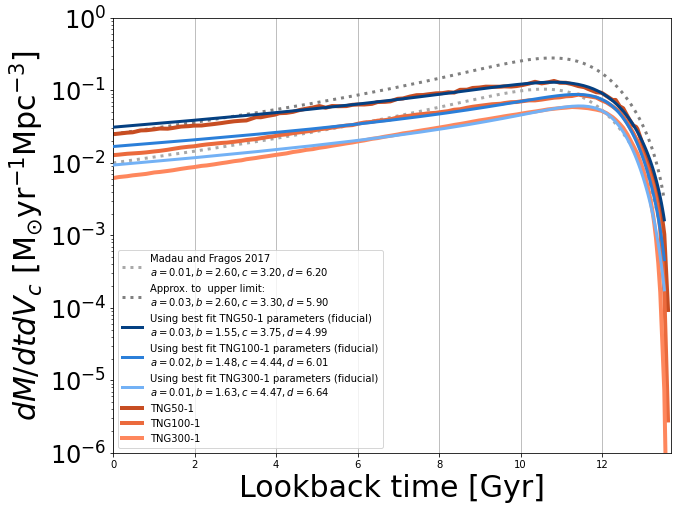

In [54]:
plot_SFR(sf_a = sf_a_best, sf_b = sf_b_best, sf_c = sf_c_best,  sf_d = sf_d_best,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7, show_fits=True)

max value 0.12965691752570246 solMass / (Mpc3 yr)  at x_max =  2.121212121212121
max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275
max value 0.06100654620675864 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275


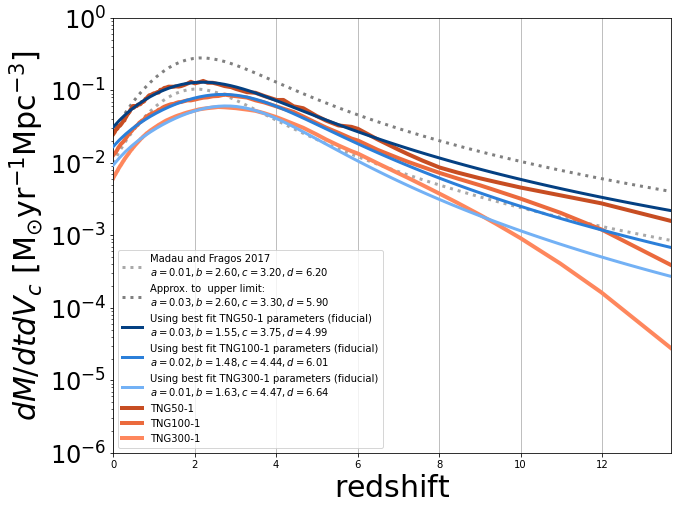

In [55]:
plot_SFR(sf_a = sf_a_best, sf_b = sf_b_best, sf_c = sf_c_best,  sf_d = sf_d_best,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7, show_fits=True)

# Merger rates

In [56]:
fid_rates = ['1_Rate_info_TNG50.h5', '1_Rate_info_TNG100.h5', '1_Rate_info_TNG300.h5'] #'1_Rate_info_TNG50_no_omega_z.h5']
fid_fit_params = ['test_best_fit_parameters_TNG50.txt', 'test_best_fit_parameters_TNG100.txt', 'test_best_fit_parameters_TNG300.txt'] #, 'best_fit_parameters_TNG50_no_omega_z.txt']
labels = ['50-1', '100-1', '300-1'] # r'50-1 no $\omega_z$']

fid_fit_param_vals = []
for file in fid_fit_params:
    try:
        mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+file,unpack=True, delimiter=',')
        fid_fit_param_vals.append([mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best])
    except ValueError:
        mu0_best, muz_best, omega0_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+file,unpack=True, delimiter=',')
        fid_fit_param_vals.append([mu0_best, muz_best, omega0_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best])

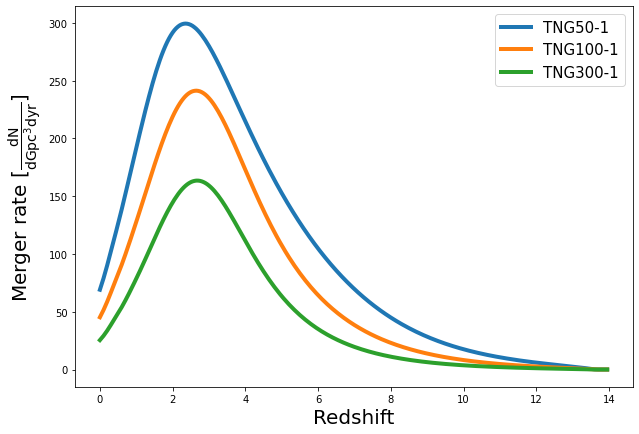

In [69]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
for i, rfile in enumerate(fid_rates):
    rate_key = 'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(fid_fit_param_vals[i][0], 3), 
                                                                                      np.round(fid_fit_param_vals[i][1], 3), 
                                                                                      np.round(fid_fit_param_vals[i][4], 3), 
                                                                                      np.round(fid_fit_param_vals[i][2], 3), 
                                                                                      np.round(fid_fit_param_vals[i][3], 3), 
                                                                                      np.round(fid_fit_param_vals[i][5], 3), 
                                                                                      np.round(fid_fit_param_vals[i][6], 3), 
                                                                                      np.round(fid_fit_param_vals[i][7], 3), 
                                                                                      np.round(fid_fit_param_vals[i][8], 3))
    
    with h5.File(data_dir + rfile ,'r') as File:
        redshifts      = File[rate_key]['redshifts'][()]
        merger_rate    = File[rate_key]['merger_rate'][()]
    
    total_merger_rate = np.sum(merger_rate, axis=0)
    plt.plot(redshifts, total_merger_rate, label='TNG%s'%labels[i], lw=4)
    
plt.xlabel('Redshift', fontsize=20)
plt.ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=20)
#plt.yscale('log')
fig.legend(bbox_to_anchor=(0.9, 0.88), fontsize=15)
plt.savefig('figures/merger_rates_TNG.png', bbox_inches='tight')

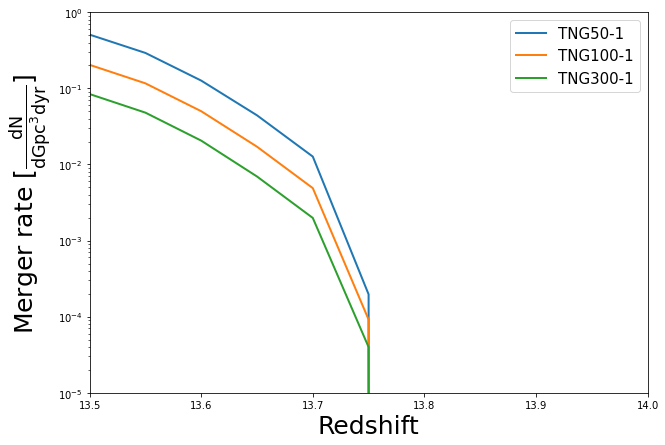

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

for i, rfile in enumerate(fid_rates):
    rate_key = 'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(fid_fit_param_vals[i][0], 3), 
                                                                                      np.round(fid_fit_param_vals[i][1], 3), 
                                                                                      np.round(fid_fit_param_vals[i][4], 3), 
                                                                                      np.round(fid_fit_param_vals[i][2], 3), 
                                                                                      np.round(fid_fit_param_vals[i][3], 3), 
                                                                                      np.round(fid_fit_param_vals[i][5], 3), 
                                                                                      np.round(fid_fit_param_vals[i][6], 3), 
                                                                                      np.round(fid_fit_param_vals[i][7], 3), 
                                                                                      np.round(fid_fit_param_vals[i][8], 3))
    
    with h5.File(data_dir + rfile ,'r') as File:
        redshifts      = File[rate_key]['redshifts'][()]
        merger_rate    = File[rate_key]['merger_rate'][()]
    
    total_merger_rate = np.sum(merger_rate, axis=0)
    plt.plot(redshifts, total_merger_rate, label='TNG%s'%labels[i], lw=2)
    
plt.xlabel('Redshift', fontsize=25)
plt.ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=25)
fig.legend(bbox_to_anchor=(0.9, 0.88), fontsize=15)
plt.xlim(13.5, 14)
plt.ylim(10**-5, 1)
plt.yscale('log')
plt.savefig('figures/merger_rates_TNG_zoomed.png', bbox_inches='tight')

# Comparing primary mass distributions

In [59]:
#get rate file names and rate keys
TNGpaths = []
rate_keys = []

for i in rates:
    TNGpaths.append('/'+i)
    
for i in fit_param_vals:
    rate_keys.append('Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(i[0], 3), np.round(i[1], 3), np.round(i[4], 3), np.round(i[2], 3), np.round(i[3], 3), np.round(i[5],3), np.round(i[6], 3), np.round(i[7], 3), np.round(i[8],3)))

In [60]:
only_stable = True 
only_CE     = True 
channel_string = 'all'
"""
pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(paths[0]), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = [rate_keys[0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf',
                           labels = ['TNG50'],
                           multipanel = False)
                           
"""

"\npltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(paths[0]), simulation_data = '/'+str(COMPASfilename),\n                           x_key = 'M_moreMassive',  rate_keys  = [rate_keys[0]], channel_string = channel_string,\n                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',\n                           only_CE = only_CE, only_stable = only_stable, \n                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf',\n                           labels = ['TNG50'],\n                           multipanel = False)\n                           \n"

Reading  /Users/sashalvna/Research/Fit_SFRD_TNG/data/COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
Path to TNG /Rate_info_TNG50.h5
Both only_stable and only_CE, I assume you just want both
Path to TNG /Rate_info_TNG100.h5
Both only_stable and only_CE, I assume you just want both
Path to TNG /Rate_info_TNG300.h5
Both only_stable and only_CE, I assume you just want both


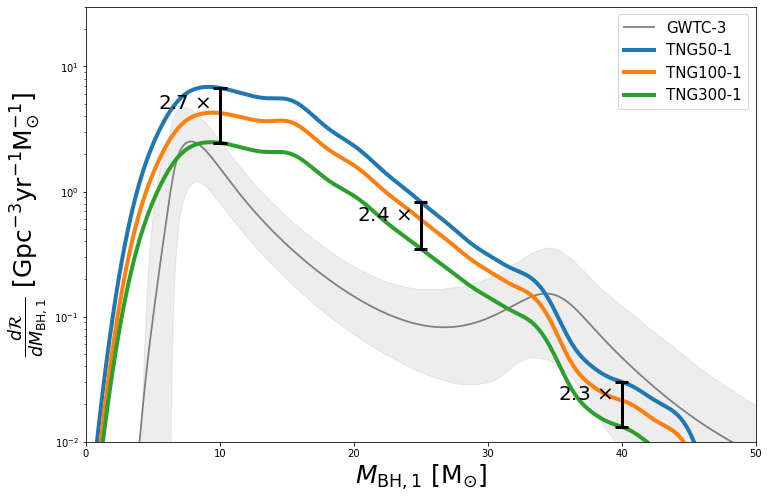

In [68]:
fig, ax = plt.subplots(figsize = (12, 8))
bins = np.arange(0.,55,2.5)
z_bin_edges = [0,0.25]
mass_binw = np.diff(bins)[0]
plot_lines = []
leg_labels = []
x_lim=(0.,50)
y_lim = (1e-2,30)
channel_string='all'
titletext = ''
xlabel = r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$'
ylabel = r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$'
Color = ['tab:blue', 'tab:orange', 'tab:green']
linestyles = ['-','-', '-']
tngs = ['TNG50-1', 'TNG100-1', 'TNG300-1']

# GWTC-3 Powerlaw + Peak Mass distribution
color_plpeak = 'grey'#'#1f78b4'
input_fname = data_dir+'o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
mass_1 = np.linspace(2, 100, 1000)
mass_ratio = np.linspace(0.1, 1, 500)
with h5.File(input_fname, "r") as f:
    mass_ppd = f["ppd"]
    mass_lines = f["lines"]
    mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
    mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
    mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
# plot the max posterior and the 95th percentile
ax.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="GWTC-3")
ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14,color=color_plpeak,zorder=0)
nplot=0

DCO = mfunc.read_data(loc = data_dir +str(COMPASfilename))
m10, m25, m40 = [], [], []

####################################################
#Loop over TNGs
for i, tngpath in enumerate(TNGpaths):
    print('Path to TNG', tngpath)

    #Reading Rate data 
    with h5.File(data_dir + tngpath ,'r') as File:
        redshifts = File[rate_keys[i]]['redshifts'][()]
        DCO_mask = File[rate_keys[i]]['DCOmask'][()] # Mask from DCO to merging systems  
        intrinsic_rate_density = File[rate_keys[i]]['merger_rate'][()]

    CEcount = 'CE_Event_Counter'
    #first bring it to the same shape as the rate table
    merging_BBH    = DCO[DCO_mask]
    #apply the additional mask based on your prefs
    if np.logical_and(only_stable, only_CE):
        print("Both only_stable and only_CE, I assume you just want both")
        channel_bool = np.full(len(merging_BBH), True)
    elif only_stable:
        channel_bool = merging_BBH[CEcount] == 0
    elif only_CE:
        channel_bool = merging_BBH[CEcount] > 0
    else:
        raise ValueError("Both only_stable =%s and only_CE=%s, set at least one to true"%(only_stable,only_CE))
    # we exclude CHE systems
    not_CHE  = merging_BBH['Stellar_Type@ZAMS(1)'] != 16
    BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)

    merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
    Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]
    
    #Calculate average rate density per z-bin
    x_vals              = merging_BBH['M_moreMassive']
    i_redshift = np.where(redshifts == 0.2)[0][0] # Rate at redshift 0.2
    Weights             = Red_intr_rate_dens[:, i_redshift]#crude_rate_density[:,0]
    
    # Get the Hist    
    hist, bin_edge = np.histogram(x_vals, weights = Weights, bins=bins)
    y_vals = hist/mass_binw
    center_bins = (bin_edge[:-1] + bin_edge[1:])/2.

    # And the KDE
    kernel = stats.gaussian_kde(x_vals, bw_method='scott', weights=Weights)
    binwidth = np.diff(bin_edge)

    m10.append(kernel(10)*sum(hist)) # append value at reference mass 
    m25.append(kernel(25)*sum(hist)) # append value at reference mass 
    m40.append(kernel(40)*sum(hist)) # append value at reference mass 
    
    x_KDE = np.arange(0.1,50.,0.1)
    KDEy_vals =  kernel(x_KDE)*sum(hist) #re-normalize the KDE
    plot_lines.append(ax.plot(x_KDE, KDEy_vals, label = tngs[nplot], color=Color[nplot], lw= 4,  zorder =i+1,ls = linestyles[nplot]))
    
    nplot += 1
    
reference_masses = [10, 25, 40]
for m, mpoint in enumerate([m10, m25, m40]):
    ax.vlines(x=reference_masses[m], ymin=min(mpoint), ymax=max(mpoint), colors='k', lw=3, zorder = 20)
    ax.hlines(y=[min(mpoint), max(mpoint)], xmin=reference_masses[m]-0.5, xmax=reference_masses[m]+0.5, linewidth=3, color='k', zorder = 20)
    ax.text(reference_masses[m] - 0.7, (max(mpoint)+min(mpoint))/2 , r'%s $\times $'%(np.round( (max(mpoint)/min(mpoint))[0] , 1)), 
        clip_on=True, ha = 'right', size = 20, zorder = 20)
        
        
#########################################
# plot values
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
    
# SFRD variaton
#plt.text(0.63, 0.85, titletext, ha = 'center', transform=ax.transAxes, size = 25)
# Channel
#plt.text(0.75, 0.66, '$\mathrm{%s \ channel}$'%(channel_string), ha = 'center', transform=ax.transAxes, size = 20)

ax.set_xlabel(xlabel, fontsize = 25)
ax.set_ylabel(ylabel, fontsize = 25)
ax.set_yscale('log')
fig.legend(bbox_to_anchor=(0.9, 0.88), fontsize=15)
fig.savefig('figures/massdist.png', bbox_inches='tight')